# Laboratorio 8 - Reducción de Dimensionalidad

**Referencia tomada del libro Hands-On Machine Learning with Scikit-Learn and Tensorflow de Aurelién Gerón**

A veces tenemos problemas que tienen muchas características de entrada.  Esto complica el problema y se le llama en Machine Learning "la maldición de la dimensionalidad".  A veces son problemas que no se pueden resolver, pero aplicando estas técnicas se puede reducir las dimensiones lo que conlleva a un problema que tiene solución.

Antes de esto sepa que al reducir dimensionalidad la información puede degradarse un poco, sí, ayuda al entrenamiento pero también hace que tu "pipeline" de machine learning sea dificil.

El training mejorará en tiempo, lo cual es una ventaja.  Se recomienda antes de utilizar estas técnicas, probar con la data sin modificaciones de, p.e., compresión, a menos que la información provenga con ruido la cual en ese caso si es necesaria filtrar.

La información, reduciendo dimensionalidad se aprovecha y mejora la manera de graficar.

Las técnicas que veremos son PCA (Principal Component Analysis), Kernel PCA y LLE.

In [0]:
# Soporte de Python 2 y Python 3
from __future__ import division, print_function, unicode_literals

# Importando librerias
import numpy as np
import os

# Estabilidad en los resultados
np.random.seed(42)

# Para graficar
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Para ignorar advertencias
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Para resumir un poco la dimensionalidad y no entrar en detalles, a medida que aumentamos la dimensionalidad, la distancia entre datos es mayor / muy dispersa.  Un nuevo dato del modelo ya entrenado será disperso de este.

En pocas palabras, a mayor dimensionalidad de datos mayor es el riesgo de 'overfitting de la data.

Incrementar el dataset de training no sirve de nada porque para tener las instancias requeridad y combatir la dimensionalidad este índice crece exponencialmente a medida que las características son añadidas.

Algunas aproximaciones son 'projection' y 'manifold'.

# Métodos de Proyección


Primero construyamos un dataset 3D:

In [0]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA using SVD decomposition

Nota: La función `svd()` retorna `U`, `s` y `Vt`, en donde `Vt` es igual a $\mathbf{V}^T$, la transpuesta de la matriz  $\mathbf{V}$:

$
\mathbf{V} =
\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [0]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

Si tenemos un dataset, la manera de conseguir los compunentes principales en por medio de una técnica llamada SVD (Single Value Decomposition).  [También se usa esta técnica en calibración de cámaras para conseguir los parámetros de por ejemplo distancia focal.]

SVD descompone la matris V.T en las matrices $U$,$\sum$,$V^T$.

Importante es saber que PCA asume que el dataset es centrado en el origen, por esto lo hacemos antes.

In [0]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [0]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [0]:
X2D_using_svd = X2D

Lo siguiente es tener entonces las proyecciones 2D del dataset en el hiperplano.  Ya el trabajo de preservar la varianza lo realizó el algoritmo de SVD.  Por consiguiente este se parecerá bastante a la data 3D.

Para proyectar tenemos que multiplicar el vector encontrado por el plano de la matriz X. $X_{d-proj} = X \bullet W_d$

## PCA utilizando Scikit-Learn

In [0]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Con Scikit-Learn, PCA, la librería se encarga sola de centrar los datos por ti.

Si comparamos el resultado anterior de PCA notaremos que nos da resultados diferentes, sin embargo lo que normalmente ocurre es que existe solamente un cambio de ejes (signo negativo).

PCA_Scikit-Learn = - PCA_custom.  Resultados son idénticos solo que con los ejes rotados.

Lo siguiente es recobrar los puntos 3D proyectados en el plano (PCA 2D)

In [0]:
X3D_inv = pca.inverse_transform(X2D)

se pierde información debido a la reducción, al proyectar se observa que no necesariamente son iguales al original.

In [13]:
np.allclose(X3D_inv, X)

False

Computamos el error de reconstrucción

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

La transformada inversa del SVD se observa como:

In [0]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

La reconstrucción de ambos métodos no es idéntica porque Scikit-Learn es su clase de PCA automaticamente toma cuidado de centrar los datos automaticamente, pero si restamos la media tenemos la misma reconstrucción.

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

El objeto PCA tiene acceso a unos sub métodos y variables de principal interes que fueron computados:

In [17]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Comparando el primero de dos componentes principales computados utilizando el método de SVD y sus componentes tenemos:

In [18]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Note que estan rotados.

Ahora veremos el 'explained variance ratio'.

In [19]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

El 'explainded variance ratio' nos da información de la proporción del dataset que yace del eje del componente principal.  Es decir, este resultado dice que 84.2% está sobre el primer eje y el 14.6% sobre el otro eje

Proyectando a una dimensiom menor (2D), perdemos aproximadamente 1.1% de la varianza:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

He aquí como computer lo explicado del radio de varianza utilizando SVD ('s' es la diagonal de la matriz 'S'):

In [21]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Clase para graficar flechas 3D (copiada de http://stackoverflow.com/questions/11140163)

In [0]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Expresamos el plano como función de 'x' y 'y'.

In [0]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Graficar el dataset 3D, el plano y la proyección sobre ese plano.

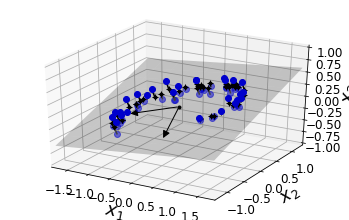

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Matplotlib 3.0.0 tiene un bug
# Ver https://github.com/matplotlib/matplotlib/issues/12239
# Actualizar a la ultima vesión o si no puede descomente estas líneas:
# for spine in ax.spines.values():
#     spine.set_visible(False)


plt.show()

Como observamos en la figura anterior la información no viene siempre en 2D, sino en dimensiones superiores probablemente.

Probablemente, y este es el caso, la información de dimensiones superior se puede analizar de manera que esta esté presente en un solo plano sub dimensional.

Para el caso superior note que todos los puntos estan correlacionados a un plano 2D.

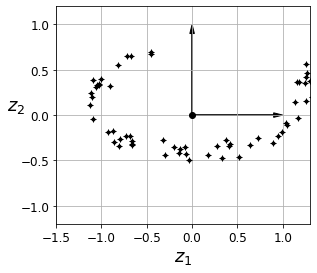

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)


Si de la información anterior tomamos y proyectamos todos los puntos sobre ese plano entonces tenemos un dataset 3D a 2D, en este caso.  Observemos que se crean nuevas características con nombre de los ejes del plano y estas corresponden a la proyección de los puntos sobre este plano.

# Aprendiendo de Manifolds


Rollo suizo:

In [0]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

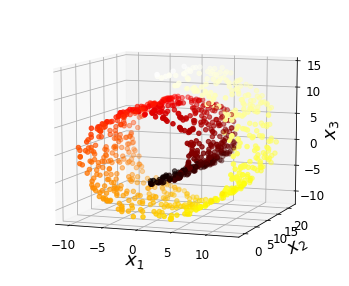

In [27]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

OK. No siempre es tan fácil separar los datos.  Note que ahora es dificil proyectar sobre un plano.

Podemos hacer una cosa que es eliminar una dimensión, probando eliminar la dimensión X3.

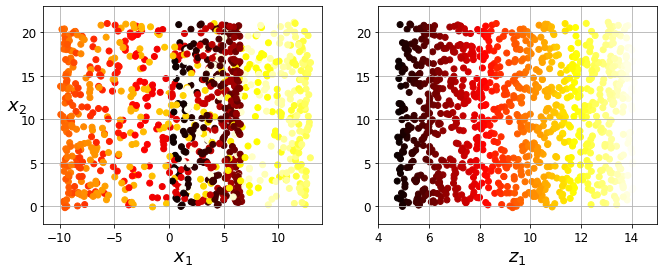

In [28]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

La figura izquierda prueba que pasa si eliminamos la dimensión X3, se ve un poco poblada y traslapada en datos.  

Ahora, en verdad lo que nos interesa es 'desenrollar' el 'rollo'.  Expandiendo tenemos la figura de la derecha.

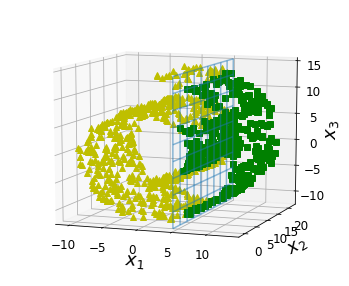

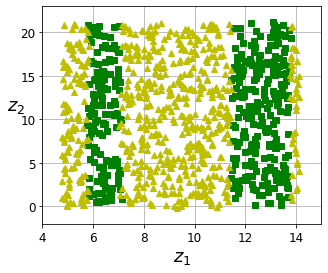

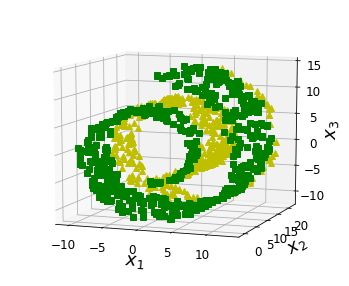

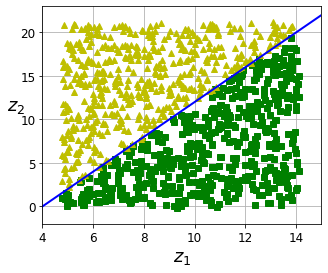

In [29]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)


plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)


plt.show()

El ejemplo anterior del rollo suizo muestra un manifold 2D.  Dice la regla que para d-dimensiones de maniforld y un espacio de n-dimensiones (d < n) se puede reensamblar en un hiperplano d.  

Del ejemplo anterior a este d = 2, n = 3, por consiguiente la reducción queda en un plano 2D, pero inicialmente presentada en 3D.

Las asumsiones del manifold son:
- La tarea de separación es mas simple si se reduce la dimensionalidad (ver la primera figura generada vs la siguiente, es más facil de separar las clases aqui el manifold es solo una proyeccion 3D a 2D)
- El manifold permite reducir y simplifcar dimensionalidad.

No siempre es tan simple note que de las dos últimas figuras la penultima es fácil discernir que parece la separación 2D ya orientada en 3D, sin embargo en la última que se 'desenroló' es más dificil su separación.

Si reduces la dimensionalidad aveces la solución no es tan simple, depende del dataset.

# PCA

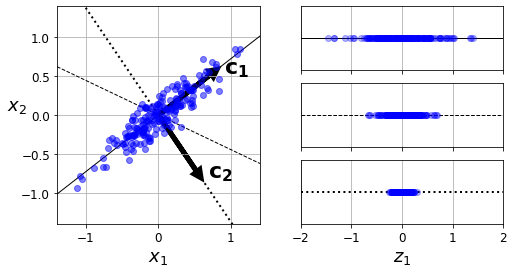

In [30]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)


plt.show()

Este método encuentra el hiperplano que se encuentra cercano a la data y luego la proyecta sobre ese plano.

Para conseguir el 'mejor' hiperplano de dimensionalidad más baja 

De la figura anterior tenemos un conjunto de datos 2D.  Si aplicamos PCA observamos que al separar en diferentes hiperplanos, la figura derecha, muestra que hay de más a menos varianza de datos desde superior a inferior.

Seria mejor elegir entonces el de mayor varianza máxima pues represente mejor el dataset, por eso se escoge el plano donde la media cuadrada de la distancia es minimizada entre el dataset original y la proyección. 

Como observamos en la figura anterior el dataset se ha 'partido' por líneas en donde la segunda es ortogonal a la primera, y así sucesivamente, dando $i_{n}$ dimensiones de componente principal llamadas $c_1$, $c_2$, $c_3$, etc. 

# MNIST compression

In [0]:
from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [0]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [0]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

La reducción de dimensionalidad nos sirve para, en gran parte, revisar visualmente, visualización de datos, en vez de reducir a veces es mejor añadir dimensiones.

Esto hará que la representación de la varianza esté lo más alta posible.

La idea del codigo anterior es preservar el 95% de la varianza del training set.

con este dato encontrado ahora podemos correr el algoritmo de PCA nuevamente.

In [0]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [36]:
pca.n_components_

154

In [37]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295708

Lo mismo que lo anterior, preserva el dato de varianza al 95%.

Otra opción seria explorar la varianza graficando la suma acumuladad (cumsum), el 'codo' nos dirá al 95% de varianza cuales son la cantida de dimensiones.

In [0]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [0]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

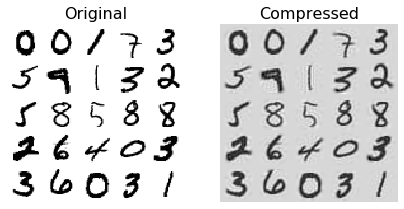

In [40]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)



In [0]:
X_reduced_pca = X_reduced

Si se analiza el MNIST se observa que a 95% de varianza tenemos menos dimensiones que las propuestas (154 en vez de 28x28x1 = 784 características).

La mayoría de la información se preserva y el dataset ahora es menor en tamaño.  Es el equivalente de compresión.

Si graficamos el dataset, luego de esta 'simplificación observamos que la información de hecho es un poco diferente pero se preserva el contenido como se ve en las figuras superiores, en donde el error de reconstrucción (distancia media cuadrada del dataset original al reconstruido).

La ecuación de PCA inversa sería identica a una de proyección:  $x_{recobrada} = x_{d-proyectada} \bullet W^T_d$

## PCA Incremental

In [42]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [0]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

Este algoritmo tiene la limitante de que neceista que todo el training quepa en memoria antes de que el SVD corra.

Lo mejor sería utilizar un PCA Incremental, alimentando al algoritmo con 'mini-batches', que son pequeñas suceciones de estos datos poco a poco.  En el caso superior de 100.  También se puede aplicar esta técnica para entrenar online (nuevos datos a una pagina o servicio por ejemplo).

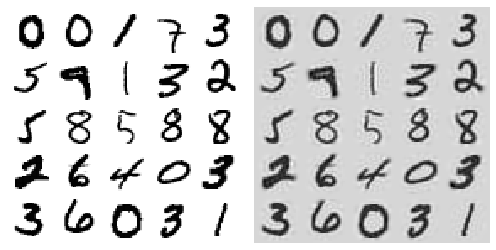

In [44]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [0]:
X_reduced_inc_pca = X_reduced

Compararemos ahora los resultados de transformar MNIST usando PCA común e incremental.  Observe que las medias son iguales.

In [46]:
np.allclose(pca.mean_, inc_pca.mean_)

True

Pero los resultados no son exactamente idénticos.  PCA Incremental da una solución aproximada pero no perfecta

In [47]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### Utilizando `memmap()`

Vamos a crear la estructura `memmap()` y copiar la data de MNIST en ella. Esta tipicamente esta hecha por el primer programa

In [0]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Otra alternativa es utilizar memmap de numpy para realizar PCA Incrmental, al final hay que eliminarlo pues ocupa espacio de memoria.

Borrando memmap, la información hará un trigger que garantizará que la información de datos es salvado al disco.

In [0]:
del X_mm

In [50]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [0]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Randomized PCA es un algoritmo estocástico (probabilistico) para encontrar la primera reducción de dimensionalidad.  La complejidad computacional es de O(m x d^2) + O(d^3) que antes era O(m x n^2) + O(n^3).

En conclusión es mucho más rápido.

## Complejidad en tiempo

Ahora midamos el tiempo regular del PCA vs el incremental y el randomized PCA:

In [52]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 3.0 seconds
    IncrementalPCA: 17.7 seconds
    PCA: 3.0 seconds
n_components = 10
    PCA: 3.3 seconds
    IncrementalPCA: 18.5 seconds
    PCA: 3.3 seconds
n_components = 154
    PCA: 7.5 seconds
    IncrementalPCA: 27.3 seconds
    PCA: 7.3 seconds


Ahora vamos a hacer que PCA y Randmized PCA sean comparados con datasets de diferentes tamaños (número de instancias):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

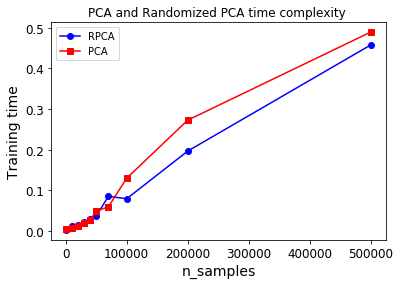

In [53]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Ahora vamos a comparar el desempeño del 2000 instancias con varias características:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

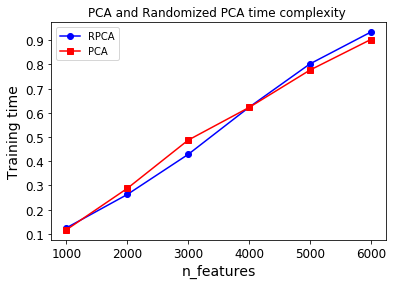

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [0]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [0]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

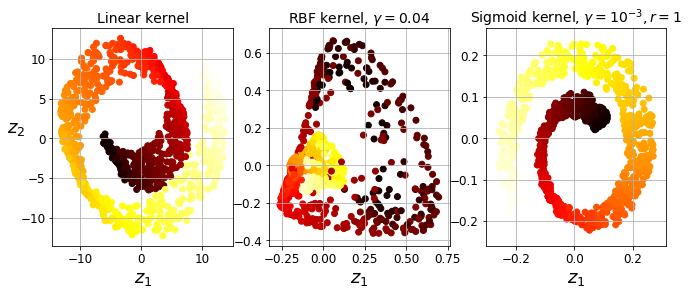

In [57]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

Del lab 5 vimos el 'truco de kernel', este insertaba en un espacio superior de dimensiones llamado 'espacio de caracteristicas' que nos permitia entonces hacer clasificación y regresion con SVMs.

El kPCA utiliza el mismo concepto.  Eficiente para proyecciones o desenrollar un manifold envuelto.

El codigo anterior realiza esta función.  trata de 'desenrollar' aplicandi diferentes tipos de kernel.

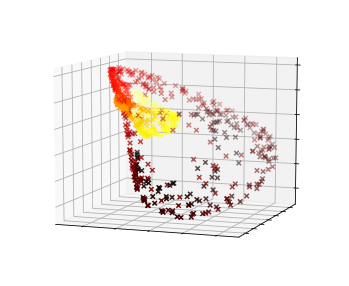

In [58]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


plt.show()

Esta aproximación es seleciconando los hiperparámetros que dan menor error de recosntrucción, la cual no es tan sencilla.

Podemos pasar con kPCA del espacio original 3D (rollo suizo) hacia el espacio reducido diretamente con el 'truco de kernel', es decir la figura superior.  Esto es equivalente a pasar de 3D -> inf dimensiones -> aplicar plano -> aplicar kernel lineal, lo que nos lleva al kPCA en 2D.  Pero no podemos reconstruir hacia atras con esta técnica pues el espacio es de muchas dimensiones.

Se puede hacer esto si se aplica un 'error de pre imagen', medir luego las idstancias de la data original y entonces seleccionar los hiperparámetros que minimizan el error de reconstrucción.

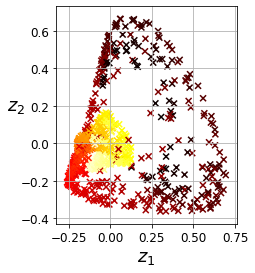

In [59]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                 

In [61]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


kPCA es un algoritmo semi-supervisado.  Podemos usar GridSearch para buscar el mejor hiperparámetro.

El codigo anterior crea un pipeline para busqueda de hiperparámetros y finalmente evaluarlo.

In [0]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [63]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576614

Las dos celdas anteriores realizan el trabajo mencionado anteriormente de medicion de distancias de pre imagen de error para realizar la reconstrucción de la data.  La solucion es entrenar un modelo de regresión proyectando X sobre el plano. 

El error de preimagen en este caso es de 32.79.

# LLE (Locally Linear Embedding)

In [0]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [0]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

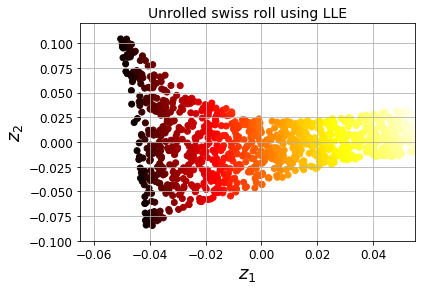

In [66]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)


plt.show()

Esta ténica basada en manifold learning mide que tan lineal es el vecino más cercano y luego busca una representación dimensional menor.  La figura anterior es el resultado de desenrollar el rollo suizo con esta técnica.

Se preservan las instancias pero no las distancias, observe que un lado está mas ensanchado que el otro, sin embargo hace un buen trabajo de desencadenar el modelo 3D a 2D.

# MDS, Isomap and t-SNE

In [0]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [0]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


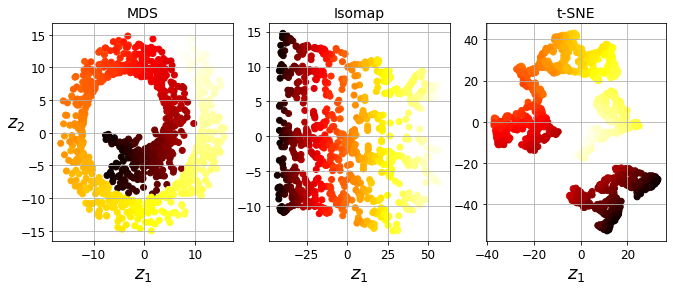

In [71]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


plt.show()

Esta tecnica (MDS) 

In [0]:
def learned_parameters(model):
    return [m for m in dir(model)
            if m.endswith("_") and not m.startswith("_")]

# Clustering - Material Extra

## Introducción – Classificación _vs_ Clustering

In [0]:
from sklearn.datasets import load_iris

In [74]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

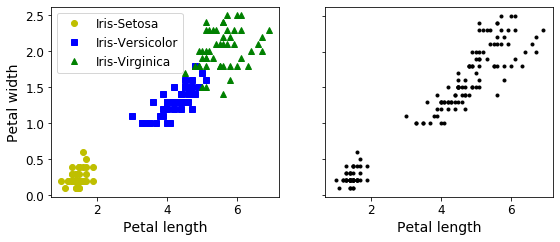

In [75]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris-Setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris-Versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris-Virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)


plt.show()

Una mezcla gausiana, explicada en el inferior puede actualente separar los clusters muy bien (usualemnte en 4 características: long. de petalo, ancho de petalo, longitud de sépalo y ancho de sépalo)

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

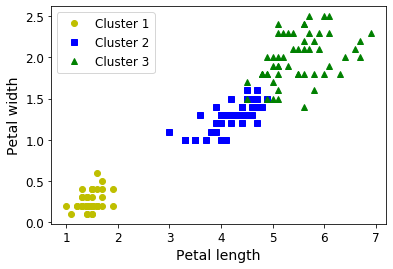

In [78]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [79]:
np.sum(y_pred==y)

145

In [80]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

## Clustering K-Means

Alunos 'blobs':

In [0]:
from sklearn.datasets import make_blobs

In [0]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [0]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Graficar:

In [0]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

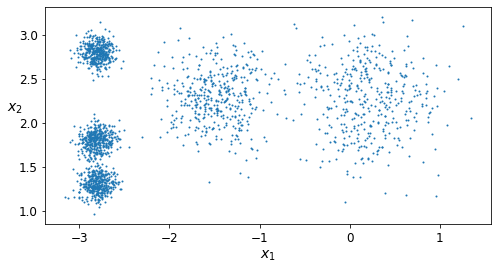

In [85]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

plt.show()

### Entrenamiento y predicción

Entrenando el K-Means en el dataset anterior.  Tratará de encontrar cada centro del conjunto de blobs y asignar instancias a los blob's más cercanos:

In [0]:
from sklearn.cluster import KMeans

In [0]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Cada instancia fue asigana a uno de los 5 clusters:

In [88]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [89]:
y_pred is kmeans.labels_

True

Y los siguientes 5 centroides fueron estimados:

In [90]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note que `KMeans` preserva las etiquetas de las instancias las cuales fueron entrenadas. Algo confuso, en este contexto, las _etiquetas_ de las instacnias de este índices del coluster fueron asignadas a:

In [91]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

Prediciendo las _etiquetas_ de las nuevas instancias:

In [92]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Límites de Decisión

Graficaremos los modelos de límites de decision.  Esto nos dará un diagrama de _Voronoi_:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

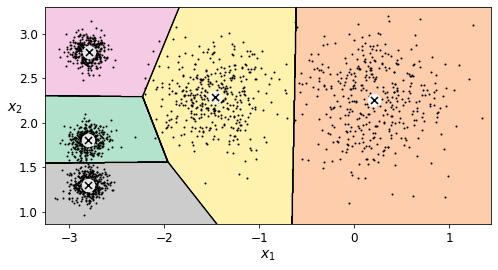

In [94]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)

plt.show()

Como se observa algunas de las instancias quedan cerca del borde y otras asignadas a un clusteri incorrecto pero es un buen trabajo de separación.

### Clustering Fuerte _vs_ Clustering Suave

Rather than arbitrarily choosing the closest cluster for each instance, which is called _hard clustering_, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [95]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Esta respuesta anterior es la distancia euclidiana entre cada instancia y cada centroide:

In [96]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### Algoritmo K-Means

Este es uno de los algoritmos de clustering más rápidos y también el de los más simples::
* Primero inicializa los centroides $k$ aleatoriamente: diferentes instancias $k$ son elegidas aleatoriamente del dataset y de los centroides que son ubicados.
* Se repite hasta converger (hasta que los centroides terminen de moverse):
    * Asigna cada instancia al centroide más cercano
    * Actualiza los centroids a ser la media de las instancias que fueron asignados a ellos.

La clase `KMeans` aplica un algoritmo de optimización por defecto. Para mantener el algoritmo original, debe de utilizar  `init="random"`, `n_init=1`and `algorithm="full"`.

In [97]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

graficar:

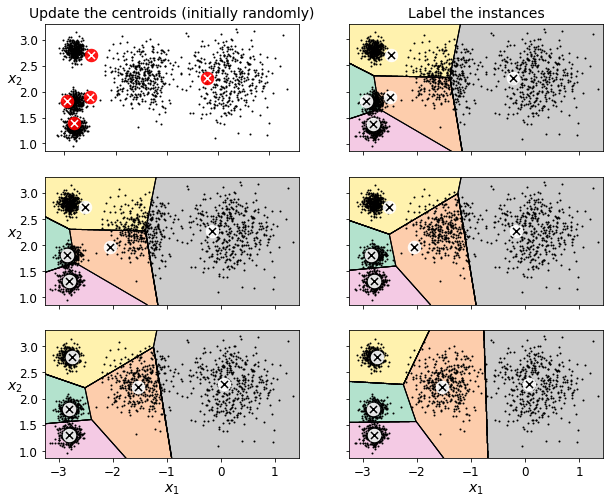

In [98]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)


plt.show()

### Variabilidad del K-Means

En el algoritmo original de K-Means los centroides son inicializados aleatoriamente y el algoritmo con ssu interaciones los mejora como se ve arriba.

Sin embargo, el problema vienee cuando K-Means se corre múltiples veces o con semillas diferentes, puede converger a soluciones diferentes como se ve en lo siguiente:

In [0]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

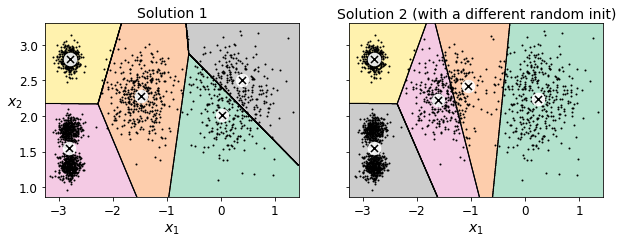

In [100]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")


plt.show()

### Inercia

Para seleccionar el mejor modelo, necesitaremos un modelo de evaluar el desempeño de K-Mean. Desafortunadamente, clustering es una tarea supervisada, así que no tendremos 'targets'.  Sin embargo lo que se puede hacer es medir la distancia de cada uno de sus centroides utilizando la métrica _inertia_:

In [101]:
kmeans.inertia_

211.5985372581684

_Inertia_ es la suma de las distancias medias cuadradas entre instancias de training y el centroide más cercano:

In [102]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

`score()`, este método retorna una inercia negativa porque el predictor _score()_ siempre debe respetar la regla de _mientras más grande mejor_.

In [103]:
kmeans.score(X)

-211.59853725816856

### Multiples Initializaciones

Así que la aproximación que resuelve el problema de variabilidad es simplemente correr un K-Means múltiples veces con diferentes estados inicializados, luego seleccionar la solución que minimice la inercia.  Por ejemplo aquí mostramos algunas malas decisiones de inercia de las figuras anteriores:

In [104]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [105]:
kmeans_rnd_init2.inertia_

237.46249169442845

Como pordá ver, tienem mayor inercia que el primer modelo "bien entrenado", la cual es probablemente peor.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [106]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

Finalizamos con el modelo inicial, el cual es ciertamente el óptimo K-means en cuanto a solucion, al menos en termins de inercia asumiendo k = 5.

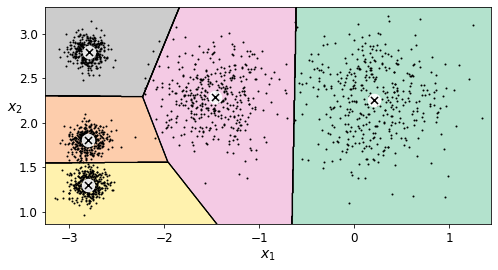

In [107]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

En vez de inicializar los centroides enteros aleatoriamente, este es preferible inicializarse utilizando el siguiente algoritmo propuesto en el [paper del 2006](https://goo.gl/eNUPw6) por David Arthur y Sergei Vassilvitskii:
* Tomando un centroide $c_1$, elegir uniformememnte aleatoriamente del dataset.
* Tomar un nuevo centro $c_i$, elegir una nueva instancia $\mathbf{x}_i$ con probabilidad: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ en donde $D(\mathbf{x}_i)$ es la distancia entre las instancias  $\mathbf{x}_i$ y el centroide más cercano que se eligió. Esta distribución de probabilidad garantiza que las instancias son seleccionadas más alá de las seleccionadas ya con centroides y son mucha más preferidas para ser los centroides..
* Repetir los pasos previos hasta que todas los centroides $k$ hayan sido elegidos.

El resto de los K-Means++ es solo algoritmos K-Means regulares. Con esta inicialización, el algoritmo de K-Means es mucho menos probable que converja a una solución subóptima, así que es posible reducir `n_init` considrablemente. La mayoria del tiempo, este es largamente compensado por la complejidad del proceso de inicialización.

Para ajustar un set de K-Means++, simplemente ajustar `init="k-means++"` (valor por defecto):

In [108]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [109]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### K-Means Acelerado

El algoritmo de K-Means puede ser significativamente acelerado desviando cálculos de distancias innecesarias:  Esto es actualmente logrado por explotar el triángulo dei inecualidad (dada por los puntos A,B y C de la distancia AC que es siempre AC ≤ AB + BC) y mantiene rastro de los límites superiores e inferioress de las distancias del os centroides (ver este [paper del 2003](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) por Charles Elkan para más detalles).

Para utilizar la variante de Elkan de K-Means, solo ajustar `algorithm="elkan"`. Note que este no soporta datos esparcidos así que el por defecto de scikit-learn usa `"elkan"` para data densa, y `"full"` (K-Means regular) para data esparcida.

In [110]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

50 loops, best of 3: 75.5 ms per loop


In [111]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

50 loops, best of 3: 93.7 ms per loop


### K-Means por Mini-Batch 

Scikit-Learn también implementa la variante de K-Means que soporta mini-batches (ver [este paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [0]:
from sklearn.cluster import MiniBatchKMeans

In [113]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [114]:
minibatch_kmeans.inertia_

211.93186531476775

Si el dataset no cabe en la memoria, la opción más simple es utilizar memmap(), como se mencionó en PCA:

In [0]:
filename = "my_mnist.data"
m, n = 50000, 28*28
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

In [116]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Si la data es tan extensa para utilizar memmap las cosas se complican y se debe escribir una función para cargar la información del siguiente batch (deberás modificar esta función para tu aplicación real pues siempre cargarás data del disco)

In [0]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Ahora que podemos entrenar y alimentar un batch a tiempo, también podemos implementar inicializaciones que mantengan el modelo con baja inercia:

In [0]:
np.random.seed(42)

In [0]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [120]:
best_kmeans.score(X)

-211.70999744411483

K-Means por Mini-batch es más rápido que el K-Means regular:

In [121]:
%timeit KMeans(n_clusters=5).fit(X)

10 loops, best of 3: 38.6 ms per loop


In [122]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

10 loops, best of 3: 20.9 ms per loop


Es *mucho* más rápido! Sin embargo, es preferido que el desempeño siempre sea por una mayor inercia y mantenga degradando a medida que _k_ inremente,  Grafiquemos la razon de radio del training entre mini batch K-Means y el regular:

In [0]:
from timeit import timeit

In [124]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

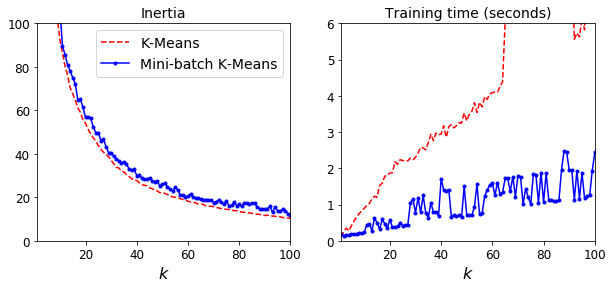

In [125]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Inertia", fontsize=14)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
#plt.ylabel("Training time (seconds)", fontsize=14)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])
#plt.legend(fontsize=14)


plt.show()

### Encontrando el Número de Clusters Óptimos

Qué pasa si el número de clusters fue ajustado para un menor o mayor valor que 5?

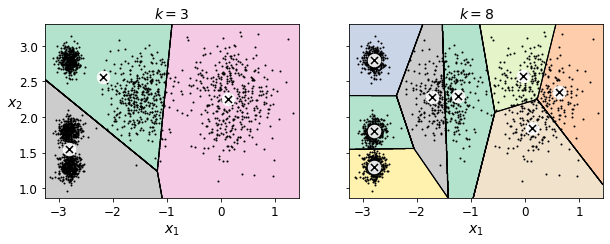

In [126]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")

plt.show()

Los modelos no hacen buen trabajo. Y la inercia?

In [127]:
kmeans_k3.inertia_

653.2167190021553

In [128]:
kmeans_k8.inertia_

119.11983416102879

No se puede simplemente tomar el valor de $k$ que minimiza la inercia, desde que este guarda la inercia y sigue decayendo cada vez que incrementamos $k$.  En efecto, nosotros podemos tomar el valor de la inercia de la función de $k$ y analizar el resultado de la curva:

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

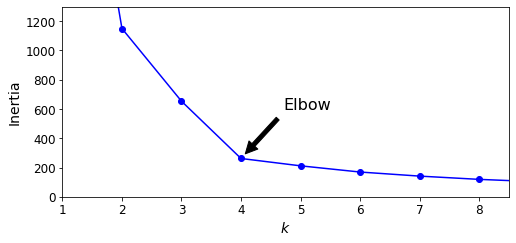

In [130]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])

plt.show()

Como podemos ver, es un hombro a $k=4$, lo que quiere decir que menos clusters que eso serán malos, y más clusters no ayudan mucho y pueden llevarlos clusters a la mitad.  Así que $k=4$, lo cual siginifca, es una buena elección.  Por supuesto en este ejemplo no es perfecto desde que esto significa que la media de los blobs en el extremo inferior izquierdo es considrada solo un cluster simple, pero es un buen cluster a pesar de.

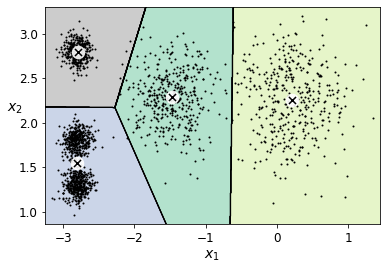

In [131]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Otra aproximación es ver la _silhouette score_, el cual es la media _silhouette coefficient_ sobre todas las instancias. Una instancia de coeficiente de silueta es igual a $(b - a)/\max(a, b)$ en donde $a$ es la distancia media a las otras instancias en el mismo cluster (es la _distancia media intra-cluster_), y $b$ es la _distancia media cercana de la distancia del cluster más cercano_, esto es, la distancia media a las instancias del cluster más cercano (definida como una que minimiza $b$, excluyendo las instancias del propio cluster). El coeficiente de silueta puede variar entre -1 y +1: un coeficiente cercano a +1 simboliza que las instancias han sido buenas entre su probpio cluster lejos de otros clusters, mientras un coeficiente de 0 simboloza que está cerca del límite de otro cluster límite, y finalmente un coeficiente -1 simboliza que la instancia ha sido asignada a otro cluster.

Graficando la función silueta de $k$:

In [0]:
from sklearn.metrics import silhouette_score

In [133]:
silhouette_score(X, kmeans.labels_)

0.34507909442492657

In [0]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

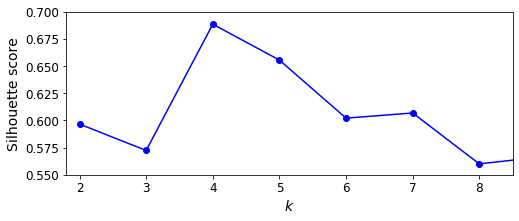

In [135]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])

plt.show()

Como se puede ver, esta visualización requiere ser mucho más rica que la previa: en particular, ademas conforma que $k=4$ es una buena alternativa, pero tambien demarca el hecho que $k=5$ es una buena decision

Y más informativo es la visualización gráfica de cada instancia de coeficiente de silueta, arreglada por el cluster ellas son asignadas a cualquier valor del coeficiente de la función.  Este es llamado el _diagrama de silueta_

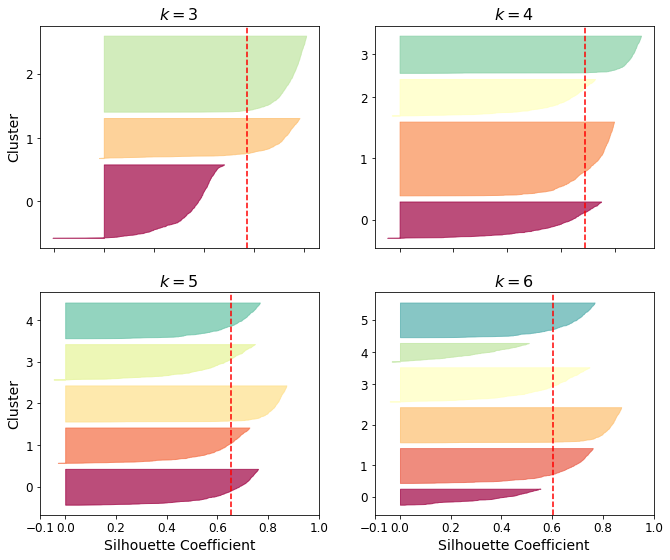

In [136]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)


plt.show()

### Limites de K-Means

In [0]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

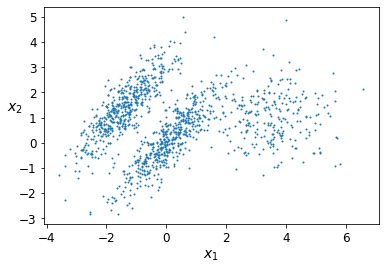

In [138]:
plot_clusters(X)

In [139]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

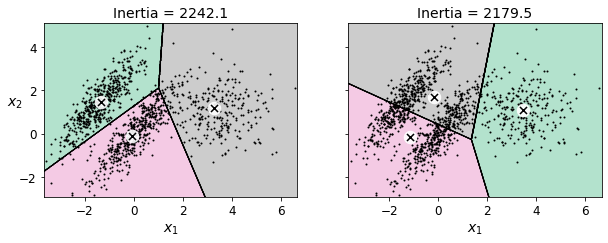

In [140]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)


plt.show()

### Utilizando Clusters para Segmentación de Imágenes

In [143]:
from matplotlib.image import imread
image = imread("roses.png")
image.shape

(534, 600, 4)

In [0]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [0]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

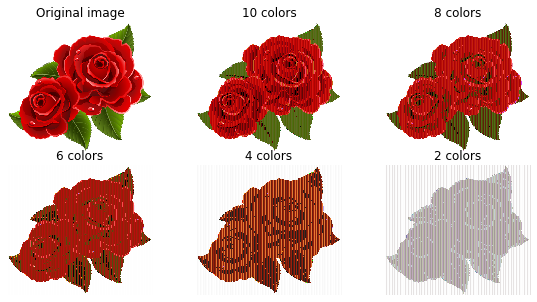

In [146]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')


plt.show()

### Using Clusters para Preprocesamiento

Ahora vamos a atacar el _dataset de digitos_ en el cual un simple MNIST contiene 1,797 en escala de grises a 8×8 imagenes representando los dígitos del 0 al 9.

In [0]:
from sklearn.datasets import load_digits

In [0]:
X_digits, y_digits = load_digits(return_X_y=True)

Dividir el dataset:

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Entrenar regresión logística

In [0]:
from sklearn.linear_model import LogisticRegression

In [152]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [153]:
log_reg.score(X_test, y_test)

0.9666666666666667

El final por el momento es 96.7% de precisión. Ahora vamos a asumir que podemos hacerlo mejor con K-Means. Nosotros odemos crear un pipeline que primeramente clusterice el training set en 50 cluster y reemplace imagenes con estas instancias de 50 clusters, entonces aplicar regresión logística:

In [0]:
from sklearn.pipeline import Pipeline

In [155]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [156]:
pipeline.score(X_test, y_test)

0.9822222222222222

In [157]:
1 - (1 - 0.9822222) / (1 - 0.9666666)

0.4666670666658673

Al ver esto, sabemos que dividiendo el porcentaje de error en un factor de 2 pero eligiento el número de cluster $k$ completamente arbitrariamente podemos hacerlo mejor.  Como K-Means es solo preprocesamiento en una línea de clasificación, encontrar un valor para $k$ es más simple que antes: no existe o se necesita un análisis de silueta o minimizar la inercia, el mejor valor de $k$ es simplemente uno que de resultados en la mejor clasificación.

In [0]:
from sklearn.model_selection import GridSearchCV

In [159]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  3.2min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
      

In [160]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [161]:
grid_clf.score(X_test, y_test)

0.9844444444444445

El desempeño mejoró a $k=90$, o sea que la respuesta es 90.

### Clustering para Aprendizaje Semi-supervisado

Otro caso de uso es clusteriong en aprendizaje semisupervisado.  En donde tenemos muchas instancias de labels a etiquetar

Regresion logistica a n_label = 50

In [0]:
n_labeled = 50

In [163]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8266666666666667

Es mucho menor a lo anterior, por supuesto.  Vamos a decir que lo podemos hacer mejor.  Primero, vamos a clusterizar el training en 50.  Entonces para cada cluster encontremos la imagen más cercana al centroide.  Nosotros podemos llamar estas imagenes representativas.

In [0]:
k = 50

In [0]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Ahora grafiquemos:

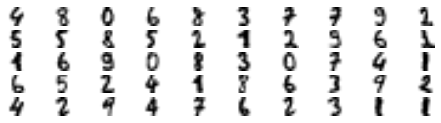

In [166]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')


plt.show()

In [0]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Ahora tenemos un dataset con solo 50 instancias etiquetadas, pero en vez de completar con instancias aleatorias, cada una de ellas es una imagen representativa del cluster.  Vamos a ver si el desempeño es mejor:

In [168]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

Se saltó de 82.7% de precisión a 92.4%, además estamos aún en el trainig de las 50 instancias.  Así que casi siempr el costo es doloroso para estas instancias, especialemnte cuando es hecha maulamente por expertos, esta es una buena idea para hacer etiquetado de las intancias que instancias aleatorias.

Podemos ir un poco más allá si propagamos las etiquetas a traves del mismo cluster?

In [0]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [170]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
log_reg.score(X_test, y_test)

0.9288888888888889

Tuvimos una mejora leve.  Pero problamemente no mejoramos mucho pues propagamos a las instancias más cercanas al centroide, porque propagar al cluster entero quizá hubiera añadido outliers.  Vamos a propagar las etiquetas del centroide mas cercano al 20avo porciento:

In [0]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [0]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [174]:
log_reg = LogisticRegression(multi_class="ovr", solver="liblinear", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [175]:
log_reg.score(X_test, y_test)

0.9422222222222222

Bien, con solo 50 instncias pudimos tener 94.2% de desempeño, el cual es cercano al desempeño de regresión logistica etiquetado como _digitos_ del dataset (el cuale fue de 96.7%).

Este está propagado por las etiquetas que son actualmente muy buenas: su precisión es alrededor del 99%:

In [176]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

Puedes intentar unas iteracciones de _active learning_:
1. Manualmente etiquetar las instancias del clasificador de estar seguro, si es posible eligiendo estas instancias de cluster. 
2. Entrenar un nuevo modelo de estas instancias adicionales.

## DBSCAN

In [0]:
from sklearn.datasets import make_moons

In [0]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [0]:
from sklearn.cluster import DBSCAN

In [180]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [181]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [182]:
len(dbscan.core_sample_indices_)

808

In [183]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [184]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [185]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [186]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [0]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

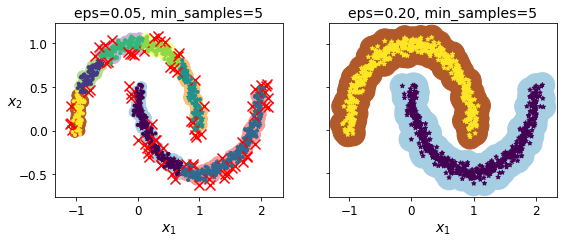

In [188]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)


plt.show()


In [0]:
dbscan = dbscan2

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [191]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [192]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [193]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

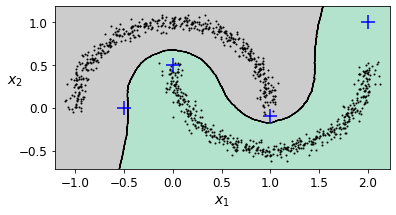

In [194]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

In [195]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Otros algoritmos de Cluster

### Spectral Clustering

In [0]:
from sklearn.cluster import SpectralClustering

In [197]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=100,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [198]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [199]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [0]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

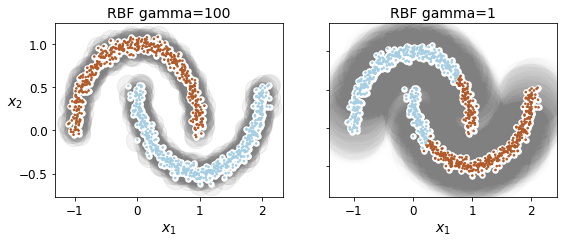

In [201]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Clustering Aglomerativo

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [0]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [204]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_components_',
 'n_connected_components_',
 'n_leaves_']

In [205]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Mezclas Gausianas

In [0]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Vamos a entrenar un mix gausiano del dataset previo

In [0]:
from sklearn.mixture import GaussianMixture

In [208]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Veremos los parámetros estimados:

In [209]:
gm.weights_

array([0.20965228, 0.4000662 , 0.39028152])

In [210]:
gm.means_

array([[ 3.39909717,  1.05933727],
       [-1.40763984,  1.42710194],
       [ 0.05135313,  0.07524095]])

In [211]:
gm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]]])

Converge?

In [212]:
gm.converged_

True

En cuantas iteraciones?

In [213]:
gm.n_iter_

4

Ahora podemos utilziar el modelo para predecir que cluster corresponde de que instancia y pertenece o que probabilidades vinieron para cada cluster.  Para esto, solo use el método `predict()` o `predict_proba()`:

In [214]:
gm.predict(X)

array([2, 2, 1, ..., 0, 0, 0])

In [215]:
gm.predict_proba(X)

array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
       [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
       [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
       ...,
       [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
       [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
       [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]])

Es un buen modelo de geenración así que las nuevas instancias de estas y sus etiquetas son:

In [216]:
X_new, y_new = gm.sample(6)
X_new

array([[ 2.95400315,  2.63680992],
       [-1.16654575,  1.62792705],
       [-1.39477712, -1.48511338],
       [ 0.27221525,  0.690366  ],
       [ 0.54095936,  0.48591934],
       [ 0.38064009, -0.56240465]])

In [217]:
y_new

array([0, 1, 2, 2, 2, 2])

Notar que estas son muestreadas secuencialmente para cada cluster.

Ud. puede estimar el logaritmo de la _densidad de la función probabilística_ en cualquier ubicación utilizando `score_samples()` method:

In [218]:
gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

Ahora verificamos que la función probabilistica de densidad integre a 1 sobre todo el espacio.  Nosotros solo vamos a tomar un cuadrado largo a través de los clusters, y recortar este en pequeños cuadrados, entonces computamos el espacio aproximadamente probable de que las instancias generarán en cada cuadrado pequeño (por multiplcar las FPD en un borde de un pequeño cuadrado por el área del otro cuadrado), y finalmente sumar estas probabilidades.  Este es el resultado muy cercano a 1:

In [219]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999217851

Ahora vamos a graficar los límites de decision (líneas - - - ) y los contornos de densidad:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

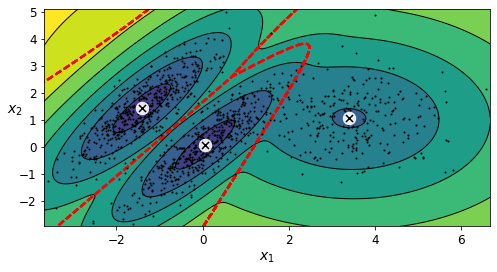

In [221]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)


plt.show()

Ud. puede imponer limitantes en las matrices de covarianza en donde el algoritmo busque ajustar el hiperparámetro `covariance_type`:
* `"full"` (por defecto): sin limitantes, todos los clusters pueden tomar una forma elipsoidal de forma y tamaño.
* `"tied"`: todos los clusters deben tomar forma, la cual puede ser de cualquier elipsoide (p.e., ellas comparten la misma matriz de covarianza).
* `"spherical"`: todos los clusters deben de ser esféricos, pero ells pueden tener diferentes diámetros (p.e., diferentes varianzas).
* `"diag"`: todos los clusters pueden tomar cualquier forma elipsoidal, cualquier forma y tamaño, pero el eje del elipsoide debe ser paralelo a los ejes (p.e., la covarianza de las matrices debe ser diagonal).

In [222]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [0]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


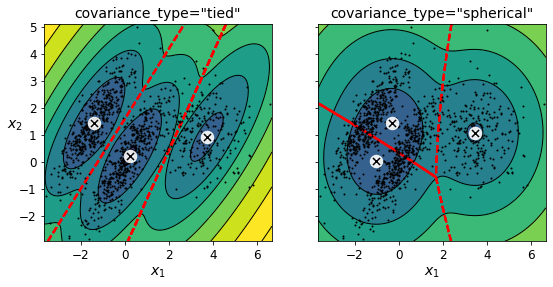

In [224]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)


plt.show()

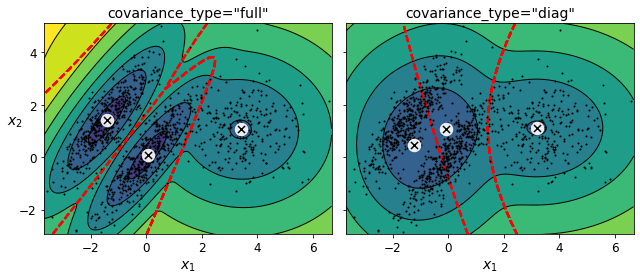

In [225]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Detección de Anomalías usando Mezcla de Gausianos

Las mezclas de gausianos se pueden utilizar para detección de anomalías: 
Instancias localizadas en regiones de baja densidad pueden ser consideradas anomalías.  Ud debe definir que umbral de densidad quiere usar.  Por ejemplo, en un sistema de manufagura que trate de detectar productos defectuosos, el radio de convergencia de estos productos defectuosos es usualmente bien conocido.  

Dicho esto, digamos que es del 4%, entonces puede proveer un umbral de densidad que al resultar en 4% delas instancias y esté localizado por debajo de este umbral es defectuoso.

In [0]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

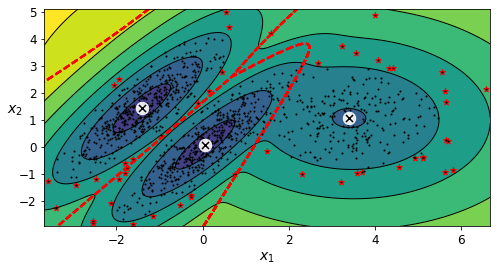

In [227]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)


plt.show()

## Selección del Modelo

No podemos utilizar la silueta de la inercia (métrica) porque ambas asumen que el cluster es esférico.  En vez de esto, podemos intentar encontrar el modelo que minimice la información teórica como la información bayesiana de criterio (BIC) o la información de criterio Akaike (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ es el número de instancias.
* $p$ es el número de parámetros aprendidos por un modelo.
* $\hat L$ es el máximo de valor de coincidencia de la función del modelo. Esta escondición probable que observa la data $\mathbf{X}$, dado el modelo y sus parámetros de optimización.

Ambos, BIC y AIC penalizan los modelos que tienen más parámetros que aprender (p.e. más clusters), y recompensa models que hacen fit bien de la data (p.e., modelos que dan mayor conicidencia de la data observada).

In [228]:
gm.bic(X)

8189.74345832983

In [229]:
gm.aic(X)

8102.518178214792

También se puede computar manualemnte:

In [0]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [231]:
bic, aic

(8189.74345832983, 8102.518178214792)

In [232]:
n_params

17

Existe otro peso por cluster, pero la suma debe dar igual a 1 así que nos movemos un grado de libertad menos, de esta manera -1.  Similarmente, los grados de libertad para una $n \times n$ matriz de covarianza no es $n^2$, pero si $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Ahora vamos a entrenar un modelo de gausianos mixtos para varios valores de $k$ y medir su BIC:

In [0]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [0]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

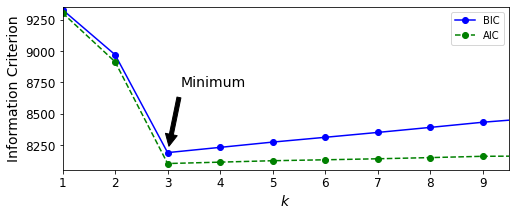

In [235]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()

plt.show()

Ahora vamos a buscar la mejor combinación de valores para ambos números de clusters y del tipo de covarianza con el hiperparámetro `covariance_type`:

In [0]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [237]:
best_k

3

In [238]:
best_covariance_type

'full'

## Mezlca de Gausianos Mixtos Bayesianos

En vez de manualmente buscar para clusters óptimos, este es posible en utilizando `BayesianGaussianMixture` el cual es capaz de dar los pesos cercanos a cero a clusters innecesarios. Solo este set de componentes de clusters tiene un valor que crea uds es mayor al número óptimo de clusters y entonces el algoritmo elimine los clusteres innecesarios automaticamente.

In [0]:
from sklearn.mixture import BayesianGaussianMixture

In [240]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

El algoritmo automaticamente detecta que solo 3 componentes fueron necesitados:

In [241]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

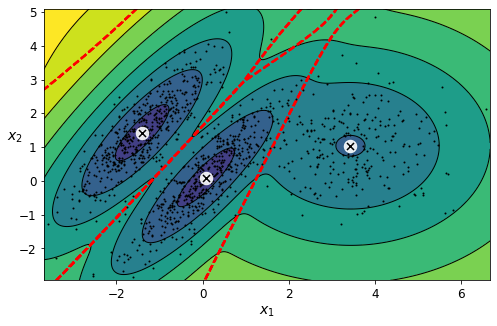

In [242]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [243]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [244]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [245]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

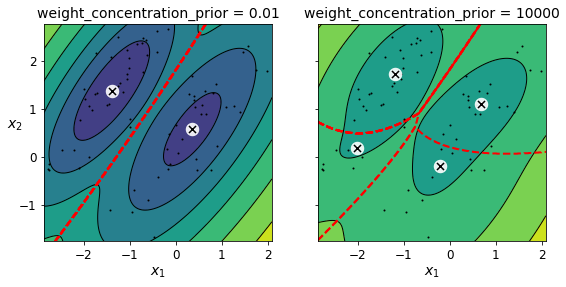

In [246]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)


plt.show()

Nota:  El heco que ud solo vea 3 regione entro de la gráfica derecha ademas de que existen 4 centroides no es un bug.  El epso del cluster superior derecho es más largo que el peso del cluster inferior derecho, así que la probabilidad a este dado punto en eta region pertenece a el cluster superior derecho , el cual es mayor que la probabilidad que pertenece al cluster inferior derecho.

In [0]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [248]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

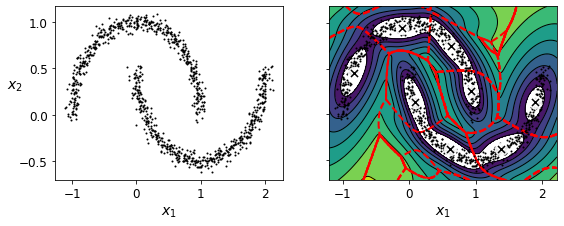

In [249]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)


plt.show()

Algo salio mal, en ves de detectar 2 clusters de lune sombreada, el algoritmo detecta 8 clusters elipsoidales. Sin embargo, la gráfica de densidad no se ve mal, así que debe ser utilziable para detección de anomalías.

## Función de Probabilidad

In [0]:
from scipy.stats import norm

In [0]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1) / (xx[1] - xx[0])

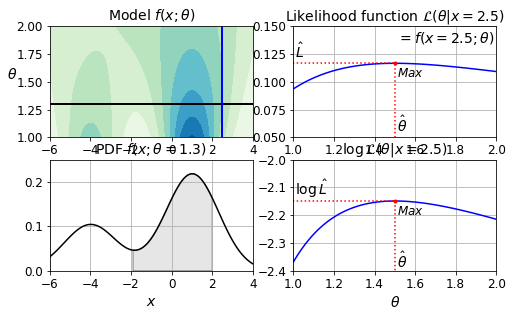

In [252]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)


plt.show()

# Laboratorio

Total 100%

Entrene el MNIST dataset con ténicas de árbol
- Cargar el MNIST dataset (5%)
- Dividir en training y test set (60k training, 10k testing) (5%)
- Entrente un random forest (clasificador) (5%)
- Mida cuanto toma en entrenar (5%)
- Evalue el resultado del modelo (10%)

Use PCA para:
- Reducir la dimensionalidad del dataset con un radio de variación del 95%. (20%)
- Entrene un nuevo random forest con el dataset reducido (10%)
- Mida cuanto toma el training (10%)

- Cuantitativamente demuestre cual es más rápido (10%)
- Evalue el clasificador con el test set (10%)
- ¿Como se compara con el clasificador previo? (10%)